# Libraries

In [ ]:
import os
from keras import utils 

In [ ]:
import tensorflow as tf

In [ ]:

print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:

# location of data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# download the data and extract it
path_to_zip = utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# construct paths
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# parameters for datasets
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# construct train and validation datasets 
train_dataset = utils.image_dataset_from_directory(train_dir,
                                                   shuffle=True,
                                                   batch_size=BATCH_SIZE,
                                                   image_size=IMG_SIZE)

validation_dataset = utils.image_dataset_from_directory(validation_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

# construct the test dataset by taking every 5th observation out of the validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

68606236/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Dataset visualization

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
t_dataset = utils.image_dataset_from_directory(train_dir,
                                                   shuffle=True,
                                                   batch_size=BATCH_SIZE,
                                                   image_size=IMG_SIZE)
t_dataset.class_names

Found 2000 files belonging to 2 classes.


['cats', 'dogs']

In [ ]:
def two_row(batch):
  class_names = ['cats', 'dogs']
  fig, ax = plt.subplots(2, 3, figsize=(10, 10))
  for images, labels in batch:
    cnt_cat = 0
    cnt_dog = 0
    i = 0
    while cnt_cat < 3 or cnt_dog < 3:
      if labels[i] == 1 and cnt_cat < 3:
        ax[0,cnt_cat].imshow(images[i].numpy().astype("uint8"))
        ax[0,cnt_cat].set_title(class_names[labels[i]])
        plt.axis("off")
        cnt_cat += 1
      elif labels[i] == 0 and cnt_dog < 3:
        ax[1,cnt_dog].imshow(images[i].numpy().astype("uint8"))
        ax[1,cnt_dog].set_title(class_names[labels[i]])
        plt.axis("off")
        cnt_dog += 1
      i += 1
      

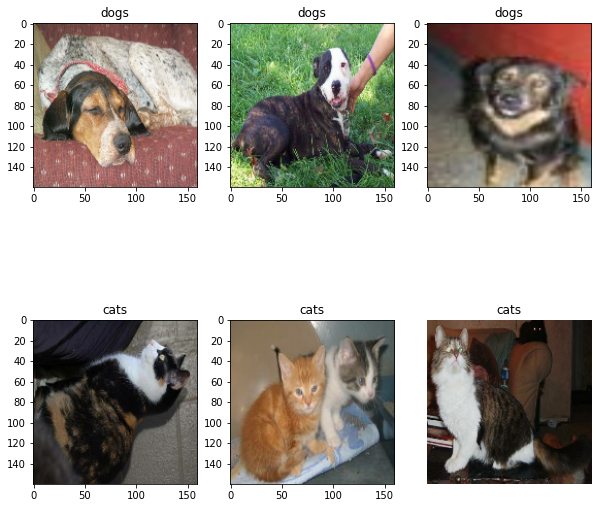

In [ ]:
two_row(train_dataset.take(1))

# Check frequencies

In [ ]:
labels_iterator= train_dataset.unbatch().map(lambda image, label: label).as_numpy_iterator()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
dogs = 0
cnt = 0
for lbl in labels_iterator:
  dogs += lbl
  cnt += 1
print("dog: ",dogs/cnt)
print("cat: ",(cnt - dogs) / cnt)

dog:  0.5
cat:  0.5


# First model: Sequential model 

Create a tf.keras.Sequential model using some of the layers we’ve discussed in class. In each model, include at least two Conv2D layers, at least two MaxPooling2D layers, at least one Flatten layer, at least one Dense layer, and at least one Dropout layer. Train your model and plot the history of the accuracy on both the training and validation sets. Give your model the name model1.

To train a model on a Dataset, use syntax like this:

history = model1.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation

Here and in later parts of this assignment, training for 20 epochs with the Dataset settings described above should be sufficient.

You don’t have to show multiple models, but please do a few experiments to try to get the best validation accuracy you can. Briefly describe a few of the things you tried. Please make sure that you are able to consistently achieve at least 52% validation accuracy in this part (i.e. just a bit better than baseline).

In bold font, describe the validation accuracy of your model during training. You don’t have to be precise. For example, “the accuracy of my model stabilized between 65% and 70% during training.”

Then, compare that to the baseline. How much better did you do?
Overfitting can be observed when the training accuracy is much higher than the validation accuracy. Do you observe overfitting in model1?

In [ ]:
import keras
from keras import layers

In [ ]:
train_dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
#one batch has a total of 32 images, 
#the output is either dog/cat for each image, binary classification
#from above, the shape of each input/img is 160,160,3 (height, width, rgb)
model1 = keras.Sequential([
    keras.Input(shape=(160,160,3)),
    layers.Conv2D(filters = 32, kernel_size = (5,5), strides=(2,2), activation="relu"),
    layers.Dropout(.1),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, (3,3), 1, activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu')
])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 32)        2432      
                                                                 
 dropout (Dropout)           (None, 78, 78, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 10368)             0

In [ ]:
optimizer = 'adam'
#sparse_categorical_crossentropy: Used as a loss function 
#for multi-class classification model where the output label is assigned integer value (0, 1, 2, 3…).
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
model1.compile(optimizer, loss, metrics)

In [ ]:
history = model1.fit(train_dataset, 
                     epochs=50, 
                     validation_data=validation_dataset)

Epoch 1/50
63/63 [==============================] - 14s 53ms/step - loss: 9.0446 - accuracy: 0.4470 - val_loss: 0.7199 - val_accuracy: 0.5371
Epoch 2/50
63/63 [==============================] - 3s 49ms/step - loss: 0.6849 - accuracy: 0.5975 - val_loss: 0.6745 - val_accuracy: 0.6040
Epoch 3/50
63/63 [==============================] - 4s 60ms/step - loss: 0.6038 - accuracy: 0.6875 - val_loss: 0.6509 - val_accuracy: 0.6597
Epoch 4/50
63/63 [==============================] - 4s 53ms/step - loss: 0.5629 - accuracy: 0.7135 - val_loss: 0.6924 - val_accuracy: 0.6275
Epoch 5/50
63/63 [==============================] - 4s 54ms/step - loss: 0.4958 - accuracy: 0.7600 - val_loss: 0.6700 - val_accuracy: 0.6597
Epoch 6/50
63/63 [==============================] - 3s 49ms/step - loss: 0.4461 - accuracy: 0.7970 - val_loss: 0.7408 - val_accuracy: 0.6411
Epoch 7/50
63/63 [==============================] - 6s 91ms/step - loss: 0.4132 - accuracy: 0.8140 - val_loss: 0.7357 - val_accuracy: 0.6646
Epoch 8/50
6

The validation accuracy of my model stabilized **somewhere between 61% and 63%** during training, more than **10% improvement comparing to the baseline.** However, the training accuracy is as high as 98.90%, an evidence for **overfitting**. 

# Second model: With data augmentation

## Random Flip

In [ ]:
#input: 3D (unbatched) or 4D (batched) tensor with shape: 
  #(..., height, width, channels), in "channels_last" format.
#output: same
r_flip = tf.keras.layers.RandomFlip(
    mode="horizontal_and_vertical", seed=2)

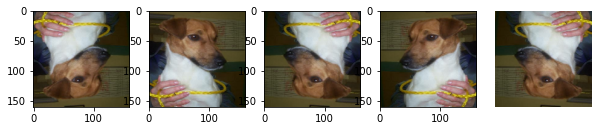

In [ ]:
batch = train_dataset.take(1)
for img,labl in batch:
  pic = img[0]
fig, ax = plt.subplots(1, 5, figsize=(10, 10))
for i in range(5):
    ax[i].imshow(r_flip(pic).numpy().astype("uint8"))
    #ax[0,i].set_title()
    plt.axis("off")
     
      

## Random Rotate

In [ ]:
## rotate
r_rotate = tf.keras.layers.RandomRotation(
    #factor (rotation angle range, unit in percent of 2 pi)
    factor = (-1,1),
    fill_mode="reflect",
    interpolation="bilinear",
    seed=2,
    fill_value=0.0
)

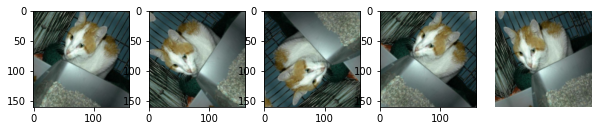

In [ ]:
batch = train_dataset.take(1)
for img,labl in batch:
  pic = img[0]
fig, ax = plt.subplots(1, 5, figsize=(10, 10))
for i in range(5):
    ax[i].imshow(r_rotate(pic).numpy().astype("uint8"))
    #ax[0,i].set_title()
    plt.axis("off")
     
      

In [ ]:
#adding preprocessing: random flip and random rotate
model2 = keras.Sequential([
    keras.Input(shape=(160,160,3)),
    r_flip,
    r_rotate,
    layers.Conv2D(filters = 32, kernel_size = (5,5), strides=(2,2), activation="relu"),
    layers.Dropout(.1),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, (3,3), 1, activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu')
])
model2.build()

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 160, 160, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 160, 160, 3)      0         
 tion)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 78, 78, 32)        2432      
                                                                 
 dropout_3 (Dropout)         (None, 78, 78, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 37, 37, 32)       

In [ ]:
model2.compile(optimizer, loss, metrics)

In [ ]:
history2 = model2.fit(train_dataset, 
                     epochs=50, 
                     validation_data = validation_dataset)

Epoch 1/50


63/63 [==============================] - 12s 136ms/step - loss: 4.0756 - accuracy: 0.4935 - val_loss: 0.7550 - val_accuracy: 0.5186
Epoch 2/50
63/63 [==============================] - 8s 122ms/step - loss: 0.7321 - accuracy: 0.5460 - val_loss: 0.7016 - val_accuracy: 0.5606
Epoch 3/50
63/63 [==============================] - 10s 148ms/step - loss: 0.7107 - accuracy: 0.5390 - val_loss: 0.7209 - val_accuracy: 0.5408
Epoch 4/50
63/63 [==============================] - 9s 143ms/step - loss: 0.7210 - accuracy: 0.5490 - val_loss: 0.6741 - val_accuracy: 0.5879
Epoch 5/50
63/63 [==============================] - 8s 117ms/step - loss: 0.6888 - accuracy: 0.5740 - val_loss: 0.6998 - val_accuracy: 0.5965
Epoch 6/50
63/63 [==============================] - 9s 140ms/step - loss: 0.6974 - accuracy: 0.5610 - val_loss: 0.6889 - val_accuracy: 0.5792
Epoch 7/50
63/63 [==============================] - 9s 142ms/step - loss: 0.6945 - accuracy: 0.5735 - val_loss: 0.6859 - val_accuracy: 0.5532
Epoch 8/50
63/6

The model performance with data augmentation included is similar to the previous one with validation accuracy reaching somewhere **between 62% and 67%**, but **without significant overfitting** as the training accuracy is somehwere around 65% also. 

# Third model: adding more data preprocesing 

In [ ]:
i = tf.keras.Input(shape=(160, 160, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(i)
preprocessor = tf.keras.Model(inputs = [i], outputs = [x])

In [ ]:
#adding preprocessing: random flip and random rotate
model3 = keras.Sequential([
    preprocessor,
    r_flip,
    r_rotate,
    layers.Conv2D(filters = 32, kernel_size = (5,5), strides=(2,2), activation="relu"),
    layers.Dropout(.1),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, (3,3), 1, activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu')
])
model3.build()

model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 160, 160, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 160, 160, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 160, 160, 3)      0         
 tion)                                                           
                                                                 
 conv2d_10 (Conv2D)          (None, 78, 78, 32)        2432      
                                                                 
 dropout_5 (Dropout)         (None, 78, 78, 32)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 39, 39, 32)       0         
 g2D)                                                 

In [ ]:
model3.compile(optimizer, loss, metrics)

In [ ]:
history3 = model3.fit(train_dataset, 
                     epochs=50, 
                     validation_data = validation_dataset)

Epoch 1/50


63/63 [==============================] - 13s 140ms/step - loss: 0.7305 - accuracy: 0.5600 - val_loss: 0.6759 - val_accuracy: 0.5941
Epoch 2/50
63/63 [==============================] - 11s 179ms/step - loss: 0.6545 - accuracy: 0.6090 - val_loss: 0.6424 - val_accuracy: 0.6324
Epoch 3/50
63/63 [==============================] - 8s 124ms/step - loss: 0.6459 - accuracy: 0.6365 - val_loss: 0.6268 - val_accuracy: 0.6522
Epoch 4/50
63/63 [==============================] - 9s 132ms/step - loss: 0.6331 - accuracy: 0.6340 - val_loss: 0.6149 - val_accuracy: 0.6844
Epoch 5/50
63/63 [==============================] - 9s 147ms/step - loss: 0.6036 - accuracy: 0.6745 - val_loss: 0.5946 - val_accuracy: 0.6757
Epoch 6/50
63/63 [==============================] - 8s 121ms/step - loss: 0.5918 - accuracy: 0.6800 - val_loss: 0.5733 - val_accuracy: 0.6943
Epoch 7/50
63/63 [==============================] - 8s 118ms/step - loss: 0.5924 - accuracy: 0.6745 - val_loss: 0.6273 - val_accuracy: 0.6448
Epoch 8/50
63/6

Given the additional preprocessing layer that normalizes the RGB values between [-1,1] before the actual training, the validation accuracy stablized somewhere **between 70% and 71% without significant overfitting**.

# Fourth Model: With transfer learning

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

i = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = tf.keras.Model(inputs = [i], outputs = [x])

In [ ]:
#adding preprocessing: random flip and random rotate
model4 = keras.Sequential([
    preprocessor,
    r_flip,
    r_rotate,
    base_model_layer,
    layers.Dropout(.1),
    layers.GlobalMaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(2, activation='softmax')
])

model4.build()

model4.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 160, 160, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 160, 160, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 160, 160, 3)      0         
 tion)                                                           
                                                                 
 model_2 (Functional)        (None, 5, 5, 1280)        2257984   
                                                                 
 dropout_11 (Dropout)        (None, 5, 5, 1280)        0         
                                                                 
 global_max_pooling2d_4 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                    

In [ ]:
model4.compile(optimizer,loss,metrics)

In [ ]:
history4 = model4.fit(train_dataset, 
                     epochs=50, 
                     validation_data = validation_dataset)

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


63/63 [==============================] - 19s 171ms/step - loss: 0.4589 - accuracy: 0.8075 - val_loss: 0.1331 - val_accuracy: 0.9505
Epoch 2/50
63/63 [==============================] - 9s 137ms/step - loss: 0.2380 - accuracy: 0.8970 - val_loss: 0.0928 - val_accuracy: 0.9703
Epoch 3/50
63/63 [==============================] - 9s 142ms/step - loss: 0.2126 - accuracy: 0.9065 - val_loss: 0.0833 - val_accuracy: 0.9740
Epoch 4/50
63/63 [==============================] - 10s 161ms/step - loss: 0.2054 - accuracy: 0.9155 - val_loss: 0.0818 - val_accuracy: 0.9740
Epoch 5/50
63/63 [==============================] - 10s 159ms/step - loss: 0.1844 - accuracy: 0.9195 - val_loss: 0.0736 - val_accuracy: 0.9678
Epoch 6/50
63/63 [==============================] - 10s 144ms/step - loss: 0.1760 - accuracy: 0.9285 - val_loss: 0.0711 - val_accuracy: 0.9728
Epoch 7/50
63/63 [==============================] - 10s 160ms/step - loss: 0.1777 - accuracy: 0.9290 - val_loss: 0.0645 - val_accuracy: 0.9752
Epoch 8/50
6

By incorporating a pretrained network and transfer the learning to our model, the final validation accuracy we reached is approximately **97.8%** with no evidence of overfitting as the train accuracy is somewhere around 96.7%. 

# Test on test set

In [ ]:
import numpy as np

https://keras.io/api/models/model_training_apis/#predictonbatch-method

In [ ]:
test_image = []
test_label = []
for image, label in test_dataset:
  test_image.append(image.numpy())
  test_label.append(label.numpy())

In [ ]:
test_imge = np.concatenate(test_image)

In [ ]:
test_label = np.concatenate(test_label)

In [ ]:
test_label[0] #dog is 1, cat is 0

0

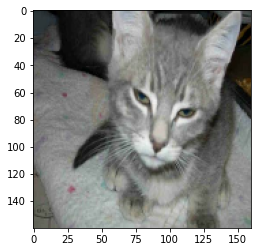

In [ ]:
plt.imshow(test_imge[0].astype("uint8"))

In [ ]:
prediction = model4.predict(test_imge)
prediction.shape

6/6 [==============================] - 0s 34ms/step


(192, 2)

In [ ]:
pred = np.argmax(prediction, axis=-1)
pred.shape == test_label.shape

True

In [ ]:
print("Test accuracy: ",np.sum([pred == test_label])/len(pred))

Test accuracy:  0.9895833333333334


We reached a final classification accuracy of **98.96%** on the test dataset by using the fourth model which incorporated color normalization, random flip/rotate, and learning transfer. 